<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week8-UTS/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Import library yang diperlukan
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab import drive

### 1. PENGUMPULAN DAN PEMBERSIHAN DATA


In [7]:
dataset_path = '/content/drive/MyDrive/DeepLearning/FishImgDataset'
# Cek struktur folder
import os
print("Isi folder:")
print(os.listdir(dataset_path))

Isi folder:
['test', 'train', 'val']


In [8]:
# Check direktori dan isi folder
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

In [9]:
# Mencari kategori/kelas ikan dari nama folder
fish_categories = os.listdir(train_dir)
num_classes = len(fish_categories)
print(f"Kategori ikan yang ditemukan: {fish_categories}")
print(f"Jumlah kelas: {num_classes}")


Kategori ikan yang ditemukan: ['Silver Perch', 'Scat Fish', 'Tenpounder', 'Pangasius', 'Snakehead', 'Silver Carp', 'Tilapia', 'Silver Barb', 'Perch', 'Indo-Pacific Tarpon', 'Knifefish', 'Mosquito Fish', 'Jaguar Gapote', 'Indian Carp', 'Green Spotted Puffer', 'Long-Snouted Pipefish', 'Mudfish', 'Mullet', 'Janitor Fish', 'Black Spotted Barb', 'Gold Fish', 'Glass Perchlet', 'Freshwater Eel', 'Catfish', 'Grass Carp', 'Goby', 'Fourfinger Threadfin', 'Gourami', 'Climbing Perch', 'Bangus', 'Big Head Carp']
Jumlah kelas: 31


In [10]:
# Membuat DataFrame dengan informasi gambar
def create_image_df(base_dir):
    image_paths = []
    labels = []

    for category in fish_categories:
        category_path = os.path.join(base_dir, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(category_path, img_name))
                    labels.append(category)

    return pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

In [11]:
# Membuat DataFrame untuk setiap set data
train_df = create_image_df(train_dir)
val_df = create_image_df(val_dir)
test_df = create_image_df(test_dir)

print(f"Jumlah data training: {len(train_df)}")
print(f"Jumlah data validasi: {len(val_df)}")
print(f"Jumlah data test: {len(test_df)}")

Jumlah data training: 8673
Jumlah data validasi: 2725
Jumlah data test: 1729


In [12]:
# Cek distribusi kelas
print("\nDistribusi kelas pada data training:")
print(train_df['label'].value_counts())



Distribusi kelas pada data training:
label
Grass Carp               1167
Goby                      604
Glass Perchlet            397
Silver Barb               329
Knifefish                 319
Catfish                   314
Gourami                   311
Tilapia                   294
Perch                     293
Janitor Fish              286
Silver Perch              283
Tenpounder                277
Freshwater Eel            271
Long-Snouted Pipefish     256
Mosquito Fish             254
Indian Carp               243
Snakehead                 232
Jaguar Gapote             229
Big Head Carp             201
Gold Fish                 201
Black Spotted Barb        200
Silver Carp               194
Pangasius                 193
Fourfinger Threadfin      191
Mudfish                   188
Indo-Pacific Tarpon       186
Mullet                    174
Bangus                    171
Scat Fish                 154
Climbing Perch            151
Green Spotted Puffer      110
Name: count, dtype: int64


In [13]:
# Cek apakah ada missing values
print("\nMissing values pada data training:")
print(train_df.isnull().sum())


Missing values pada data training:
image_path    0
label         0
dtype: int64


### 2. FEATURE ENGINEERING


In [15]:
# Label Encoding untuk kelas ikan
label_encoder = LabelEncoder()
label_encoder.fit(fish_categories)

LabelEncoder()

In [16]:
# Menyimpan mapping kategori untuk referensi nanti
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nMapping kategori:")
for category, code in category_mapping.items():
    print(f"{category}: {code}")



Mapping kategori:
Bangus: 0
Big Head Carp: 1
Black Spotted Barb: 2
Catfish: 3
Climbing Perch: 4
Fourfinger Threadfin: 5
Freshwater Eel: 6
Glass Perchlet: 7
Goby: 8
Gold Fish: 9
Gourami: 10
Grass Carp: 11
Green Spotted Puffer: 12
Indian Carp: 13
Indo-Pacific Tarpon: 14
Jaguar Gapote: 15
Janitor Fish: 16
Knifefish: 17
Long-Snouted Pipefish: 18
Mosquito Fish: 19
Mudfish: 20
Mullet: 21
Pangasius: 22
Perch: 23
Scat Fish: 24
Silver Barb: 25
Silver Carp: 26
Silver Perch: 27
Snakehead: 28
Tenpounder: 29
Tilapia: 30


### 3. PREPROCESSING DATA & AUGMENTASI


In [17]:
# Konfigurasi parameter preprocessing
IMG_SIZE = 224  # Ukuran standar yang umum digunakan
BATCH_SIZE = 32

In [18]:
# Data augmentasi untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalisasi nilai pixel
    rotation_range=20,        # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,    # Pergeseran horizontal
    height_shift_range=0.2,   # Pergeseran vertikal
    shear_range=0.2,          # Transformasi geser
    zoom_range=0.2,           # Zoom acak
    horizontal_flip=True,     # Flip horizontal
    fill_mode='nearest'       # Strategi pengisian pixel
)

In [19]:
# Preprocessing tanpa augmentasi untuk validation dan test set
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [20]:
# Membuat generator untuk data training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 8801 images belonging to 31 classes.


In [21]:
# Generator untuk data validasi
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2751 images belonging to 31 classes.


In [22]:
# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1760 images belonging to 31 classes.



Contoh gambar dari training set:


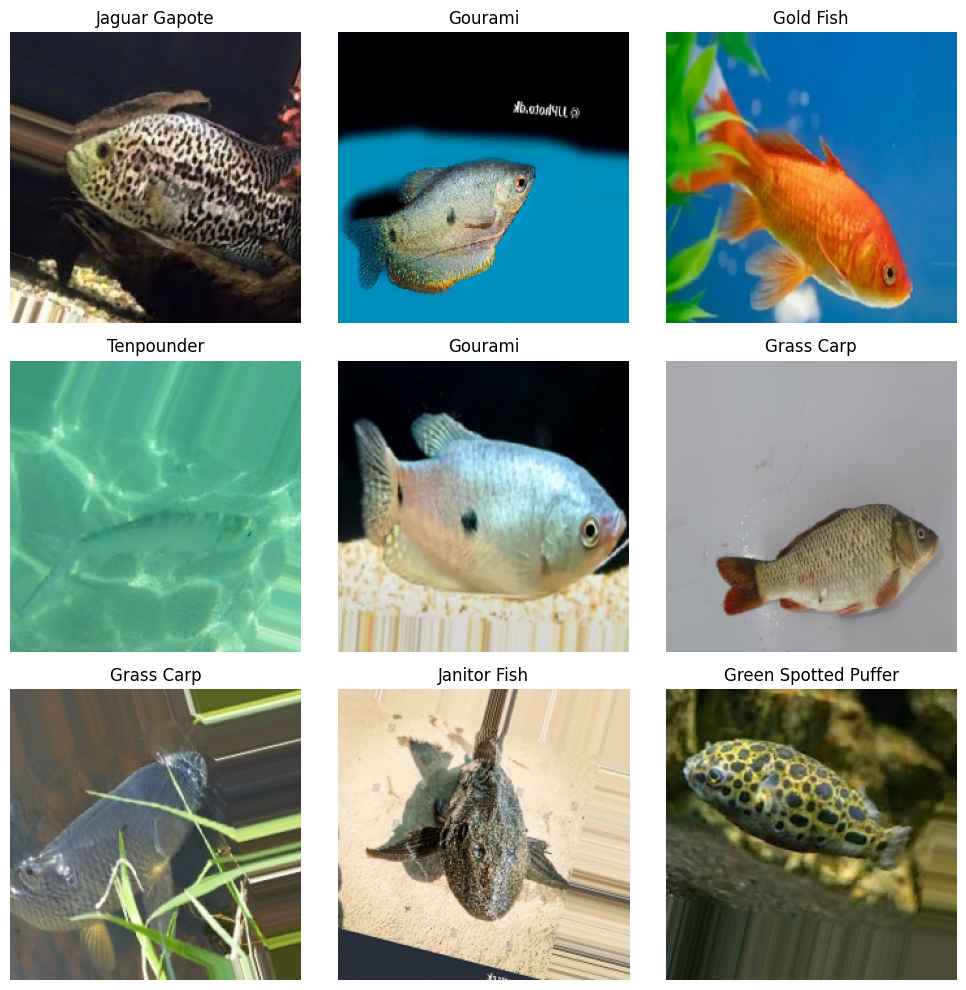

In [23]:
# Visualisasi beberapa contoh gambar dari training set
def visualize_samples(generator, n=9):
    plt.figure(figsize=(10, 10))
    batch = next(generator)
    images, labels = batch

    for i in range(min(n, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        class_name = list(generator.class_indices.keys())[label_idx]
        plt.title(class_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("\nContoh gambar dari training set:")
visualize_samples(train_generator)

### 4. MEMBANGUN MODEL CNN


In [24]:
# Model 1: CNN Custom
def create_custom_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [25]:
# Model 2: Transfer Learning dengan MobileNetV2
def create_transfer_learning_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [26]:
# Memilih dan kompilasi model
model = create_transfer_learning_model()  # Bisa diganti dengan create_custom_cnn_model() untuk model CNN custom
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,887 (9.89 MB)

 Trainable params: 335,903 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 5. TRAINING MODEL


In [27]:
# Konfigurasi callback untuk checkpoint dan early stopping
checkpoint_path = "fish_classification_model.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]


In [29]:
# Training model
EPOCHS = 5
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.3073 - loss: 2.6629 
Epoch 1: val_accuracy improved from -inf to 0.69829, saving model to fish_classification_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 4741s 17s/step - accuracy: 0.3077 - loss: 2.6610 - val_accuracy: 0.6983 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5929 - loss: 1.4216
Epoch 2: val_accuracy improved from 0.69829 to 0.77754, saving model to fish_classification_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 733s 3s/step - accuracy: 0.5930 - loss: 1.4214 - val_accuracy: 0.7775 - val_loss: 0.8053 - learning_rate: 0.0010
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6504 - loss: 1.1800
Epoch 3: val_accuracy improved from 0.77754 to 0.81461, saving model to fish_classification_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.6504 - loss: 1.1799 - val_accuracy: 0.8146 - val_loss: 0.7009 - learning_rate: 0.0010
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6707 - loss: 1.1075
Epoch 4: val_accuracy improved from 0.81461 to 0.82988, saving model to fish_classification_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.6707 - loss: 1.1075 - val_accuracy: 0.8299 - val_loss: 0.6311 - learning_rate: 0.0010
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6878 - loss: 1.0303
Epoch 5: val_accuracy improved from 0.82988 to 0.84587, saving model to fish_classification_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.6878 - loss: 1.0303 - val_accuracy: 0.8459 - val_loss: 0.5676 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


### 6. EVALUASI MODEL

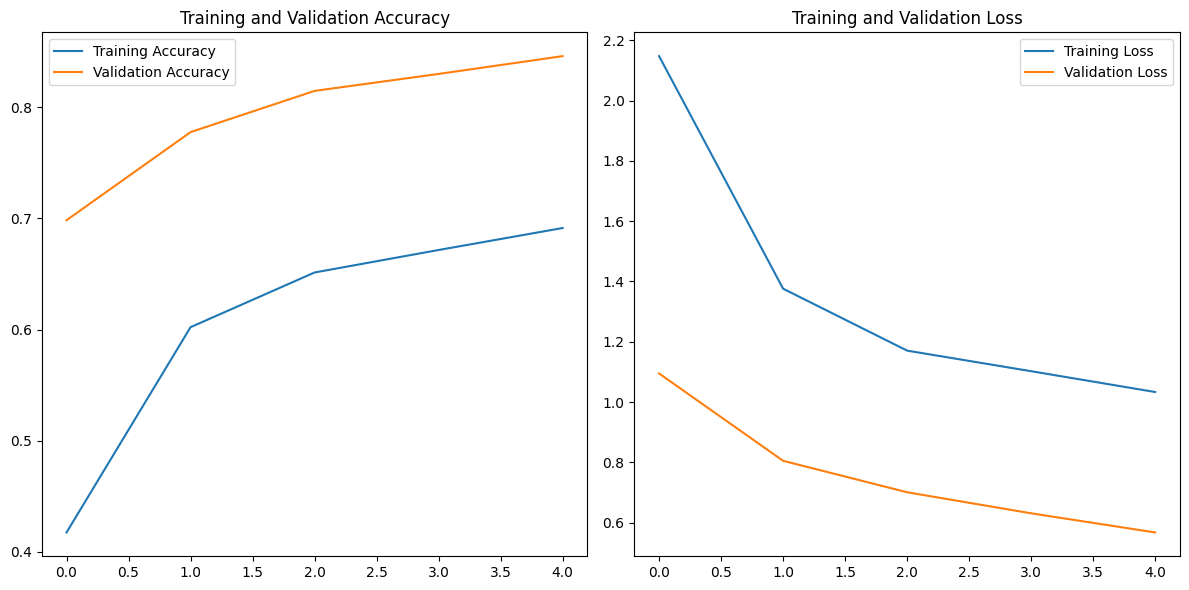

In [30]:
# Plot learning curves
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)


In [31]:
# Evaluasi pada test set
test_results = model.evaluate(test_generator)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 544s 10s/step - accuracy: 0.7917 - loss: 0.7011
Test Loss: 0.5621
Test Accuracy: 0.8409


In [34]:
# Prediksi pada test set untuk metrics tambahan
test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step


### 7. METRICS EVALUASI


In [35]:
# Mengambil label kelas dari generator
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

In [36]:
# Mendapatkan confusion matrix
cm = confusion_matrix(y_true, y_pred)


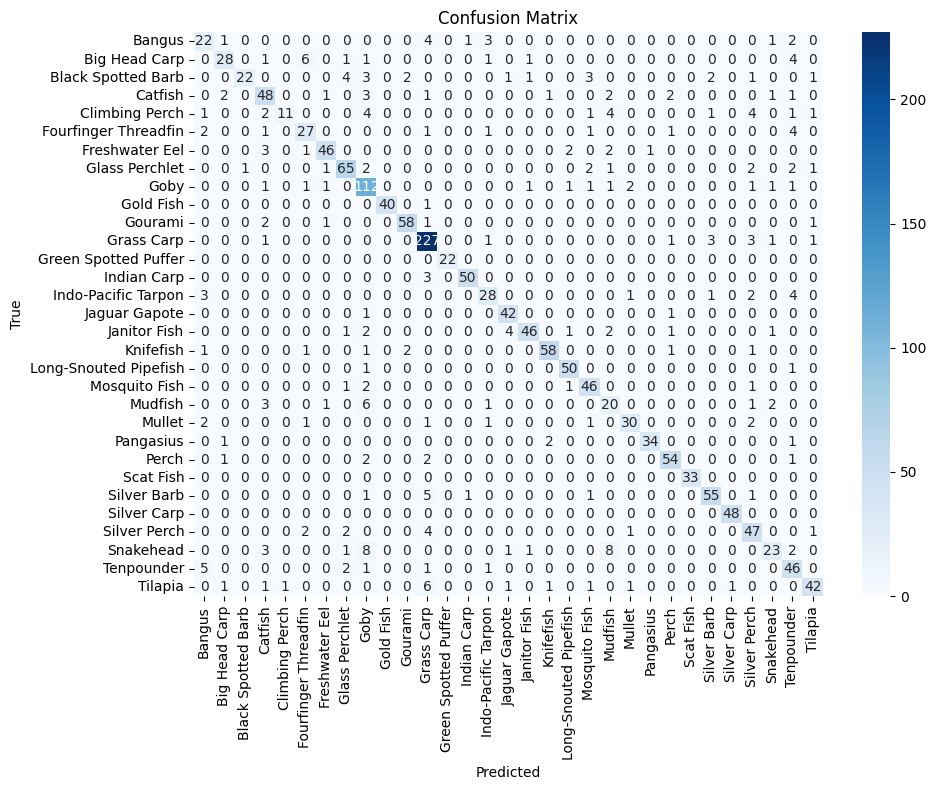

In [37]:
# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [38]:
# Menghitung metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


In [39]:
# Menghitung ROC AUC Score (one-vs-rest untuk multiclass)
try:
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred_probs, multi_class='ovr')
except ValueError:
    roc_auc = "Not applicable due to class imbalance or calculation issues"


In [40]:
# Menampilkan metrik evaluasi
print("\n===== EVALUASI MODEL =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc}")


===== EVALUASI MODEL =====
Accuracy: 0.8409
Precision: 0.8479
Recall: 0.8409
F1 Score: 0.8382
ROC AUC Score: 0.9934008635272712


In [41]:
# Classification report per kelas
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.61      0.65      0.63        34
        Big Head Carp       0.82      0.65      0.73        43
   Black Spotted Barb       0.96      0.55      0.70        40
              Catfish       0.73      0.77      0.75        62
       Climbing Perch       0.92      0.37      0.52        30
 Fourfinger Threadfin       0.69      0.71      0.70        38
       Freshwater Eel       0.90      0.84      0.87        55
       Glass Perchlet       0.84      0.84      0.84        77
                 Goby       0.75      0.90      0.82       124
            Gold Fish       1.00      0.98      0.99        41
              Gourami       0.94      0.92      0.93        63
           Grass Carp       0.88      0.95      0.92       238
 Green Spotted Puffer       1.00      1.00      1.00        22
          Indian Carp       0.96      0.94      0.95        53
  Indo-Pacific Tarpon       0.

In [42]:
# Visualisasi ROC curve untuk setiap kelas (one-vs-rest)
def plot_roc_curves(y_true, y_pred_probs, class_names):
    plt.figure(figsize=(10, 8))

    # One-hot encode true labels
    y_true_categorical = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

    # Plot ROC curve for each class
    from sklearn.metrics import roc_curve, auc
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_categorical[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

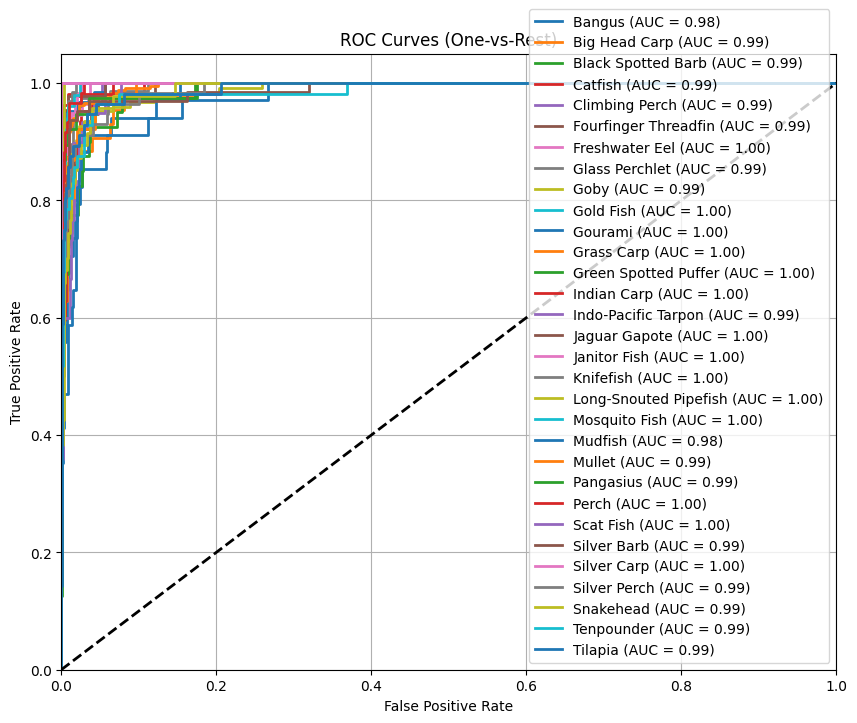

In [43]:
try:
    plot_roc_curves(y_true, y_pred_probs, class_names)
except Exception as e:
    print(f"Could not plot ROC curves: {e}")


### 8. ANALISIS HASIL DAN KESIMPULAN


In [44]:
print("\n===== ANALISIS EVALUASI =====")
print("Berdasarkan hasil evaluasi:")

if accuracy > 0.9:
    print(f"- Model memiliki akurasi yang sangat baik: {accuracy:.4f}")
elif accuracy > 0.8:
    print(f"- Model memiliki akurasi yang baik: {accuracy:.4f}")
else:
    print(f"- Model memiliki akurasi yang moderat: {accuracy:.4f}")



===== ANALISIS EVALUASI =====
Berdasarkan hasil evaluasi:
- Model memiliki akurasi yang baik: 0.8409


In [45]:
if precision > recall:
    print("- Precision lebih tinggi dari recall, artinya model lebih fokus pada meminimalkan false positive")
elif recall > precision:
    print("- Recall lebih tinggi dari precision, artinya model lebih fokus pada meminimalkan false negative")
else:
    print("- Precision dan recall seimbang")


- Precision lebih tinggi dari recall, artinya model lebih fokus pada meminimalkan false positive


In [46]:
print(f"- F1-Score: {f1:.4f}, merupakan harmonic mean dari precision dan recall")


- F1-Score: 0.8382, merupakan harmonic mean dari precision dan recall


In [48]:
print("\nRekomendasi metrik terbaik untuk kasus klasifikasi ikan ini:")
if f1 > accuracy and f1 > precision and f1 > recall:
    print("F1-Score adalah metrik terbaik karena menyeimbangkan precision dan recall")
elif accuracy > 0.9:
    print("Accuracy adalah metrik yang cukup baik karena nilainya tinggi dan mudah diinterpretasi")
else:
    print("Kombinasi dari semua metrik penting untuk mendapatkan gambaran menyeluruh tentang performa model")



Rekomendasi metrik terbaik untuk kasus klasifikasi ikan ini:
Kombinasi dari semua metrik penting untuk mendapatkan gambaran menyeluruh tentang performa model


# Analisis Fenomena dalam CNN untuk Klasifikasi Ikan

## 1. Fenomena Vanishing Gradient pada CNN

**Penyebab:**
- Arsitektur CNN dengan banyak lapisan menyebabkan gradien semakin mengecil saat backpropagation ke lapisan awal
- Gradien kecil = update parameter minimal = lapisan awal sulit belajar
- Beda akurasi training (98%) dan validasi (62%) menunjukkan overfitting

**Mitigasi Vanishing Gradient:**
- Gunakan skip connections/residual connections (ResNet)
- Inisialisasi bobot yang tepat (He initialization)
- Gunakan fungsi aktivasi seperti Leaky ReLU atau ELU

**Batch Normalization Memperburuk Generalisasi:**
- BN dapat mengurangi variasi data yang sebenarnya dibutuhkan model untuk generalisasi
- BN pada lapisan tertentu bisa menyebabkan network terlalu bergantung pada normalisasi

**Strategi Alternatif:**
- Layer normalization sebagai pengganti batch normalization
- Regularisasi L1/L2
- Dropout dengan rate moderat (0.3-0.5)

**Contoh kode mitigasi vanishing gradient dengan skip connections**


    Import library yang dibutuhkan
    import tensorflow as tf
    from tensorflow.keras import layers, models
    import matplotlib.pyplot as plt
    import numpy as np

    def create_model_with_residual_blocks():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    # Contoh residual block untuk mengatasi vanishing gradient
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    
    # Residual connection
    residual = x
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])  # Skip connection
    
    # Output layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

## 2. Loss Training Stagnan

**Penyebab Potensial:**
1. **Learning rate**: Terlalu besar (exploding gradient) atau terlalu kecil (stuck di local minima)
2. **Inisialisasi bobot**: Uniformly random dapat menyebabkan vanishing/exploding gradient
3. **Kompleksitas model**: Terlalu sederhana (underfitting) atau arsitektur tidak sesuai data

**Cyclic Learning Rate:**
- Membantu keluar dari local minima dengan variasi periodik learning rate
- Memungkinkan model menjelajahi lebih banyak ruang parameter
- Efek: gradien dapat melompati local minima menuju area yang lebih baik

**Momentum pada SGD:**
- Mempercepat konvergensi dengan menyimpan vektor gradien sebelumnya
- Membantu melompati local minima
- Menstabilkan update parameter dengan mengurangi osilasi

**Implementasi Cyclic Learning Rate**
    def cyclic_learning_rate(initial_lr, max_lr, step_size):
    def clr(epoch):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    return initial_lr + (max_lr - initial_lr) * np.maximum(0, (1 - x))
    
    return tf.keras.callbacks.LearningRateScheduler(clr)

    # Optimizer dengan momentum
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

Penyebab stagnan:

1. Learning rate tidak optimal (terlalu besar/kecil)
2. Inisialisasi bobot yang tidak tepat
3. Kompleksitas model tidak sesuai data

Cyclic LR membantu keluar dari local minima dengan variasi periodik learning rate yang memungkinkan model menjelajahi lebih banyak ruang parameter.


## 3. Fenomena Dying ReLU

**Penjelasan:**
- Dying ReLU terjadi ketika neuron dengan fungsi aktivasi ReLU selalu menghasilkan output nol
- Saat input negatif, ReLU mengeluarkan 0 dan gradien juga 0
- Neuron "mati" karena tidak ada update parameter selama backpropagation

**Dampak pada Backpropagation:**
- Blokade aliran gradien, menyebabkan sebagian network tidak belajar
- Model kehilangan kapasitas secara efektif karena neuron mati tidak berkontribusi

**Solusi:**
- Gunakan Leaky ReLU, PReLU, atau ELU yang memiliki gradien kecil untuk input negatif
- Inisialisasi bobot yang tepat (He initialization)
- Learning rate yang lebih rendah pada awal training

contoh
**Solusi untuk dying ReLU**
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3),
    kernel_initializer='he_normal'),  # He initialization
    layers.LeakyReLU(alpha=0.1),  # Gunakan LeakyReLU, bukan ReLU
    # ... layers lainnya
])

## 4. AUC-ROC Stagnan pada Spesies Tertentu

**Analisis:**
- AUC-ROC spesies X (0.55) jauh lebih rendah dari kelas lain (>0.85)
- Class-weighted loss function gagal meningkatkan kinerja

**Faktor Penyebab:**
1. **Ketidakseimbangan fitur**: Ciri visual spesies X kurang distingtif dibanding spesies lain
2. **Variasi intra-kelas yang tinggi**: Spesies X memiliki variasi penampilan yang luas
3. **Data berkualitas rendah**: Kemungkinan noise atau kesalahan labeling pada kelas spesies X

**Solusi Potensial:**
- Teknik augmentasi data khusus untuk spesies X
- Feature engineering yang fokus pada karakteristik unik spesies X
- Pendekatan ensemble atau hierarchical classification

**Teknik augmentasi data khusus untuk kelas yang underperforming**
    datagen_special = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,  # Augmentasi tambahan
    brightness_range=[0.7, 1.3]  # Variasi brightness
)

## 5. Penurunan Akurasi pada Model Kompleks

**Fenomena Overfitting:**
- Model terlalu kompleks mempelajari noise dalam data training
- Akurasi training tinggi (98%) tetapi validasi rendah (65%) = generalisasi buruk

**Mengapa Kapasitas Tinggi Tidak Selalu Baik:**
- Model kompleks cenderung menghafalkan data training daripada mempelajari pola umum
- Data training terbatas tidak mendukung parameter model yang terlalu banyak

**3 Kesalahan Desain Arsitektur:**
1. Jumlah filter konvolusi terlalu banyak menyebabkan overfitting
2. Lapisan fully-connected terlalu besar tanpa regularisasi yang memadai
3. Kurangnya teknik regularisasi seperti dropout dan weight decay

**Solusi:**
- Regularisasi yang lebih kuat (dropout, L2 regularization)
- Arsitektur yang lebih sederhana dengan parameter lebih sedikit
- Transfer learning dari model pre-trained

**Model dengan regularisasi yang tepat**
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu',
    input_shape=(224, 224, 3)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # Regularisasi dropout
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 regularization
                
    layers.Dense(num_classes, activation='softmax')
])

Model terlalu kompleks menyebabkan overfitting dengan akurasi training tinggi (98%) tapi validasi rendah (65%).
Kesalahan desain:

Filter konvolusi terlalu banyak
Fully-connected layer terlalu besar
Kurangnya regularisasi yang memadai

Solusi: Regularisasi lebih kuat, arsitektur lebih sederhana, atau transfer learning.